In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
import numpy as np

### Definição do modelo

In [3]:
OUTPUT_CHANNELS = 3

# Paths:
PATH_INPUT = 'sprites-processed-shadows'
PATH_REAL = 'sprites-processed'

# Tamanho de cada imagem:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# The facade training set consist of 400 images
BUFFER_SIZE = 2000
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

# Treinamento:
LAMBDA = 100

In [4]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Leitura da entrada

In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_png(image)
    return tf.cast(image, tf.float32)

def resize(image, height, width):
    return tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def random_crop(image, seed):
    return tf.image.stateless_random_crop(image, seed=seed, size=[IMG_HEIGHT, IMG_WIDTH, tf.shape(image)[2]])

def normalize(image):
    return (image / 127.5) - 1

def random_jitter(image, seed):
  # Resizing to 286x286 and random cropping back to 256x256
  image = resize(image, 286, 286)
  image = random_crop(image, seed)
  image = tf.image.stateless_random_flip_left_right(image, seed)

  return image

def gen_seed_pair():
   return [np.random.randint(-1e9, +1e9), np.random.randint(-1e9, +1e9)]

def load_image_pair(image_file_input, image_file_real):
  seed = gen_seed_pair()
  image_input, image_real = load(image_file_input), load(image_file_real)
  image_input, image_real = random_jitter(image_input, seed), random_jitter(image_real, seed)
  
  return normalize(image_input), normalize(image_real)

#### Teste de leitura

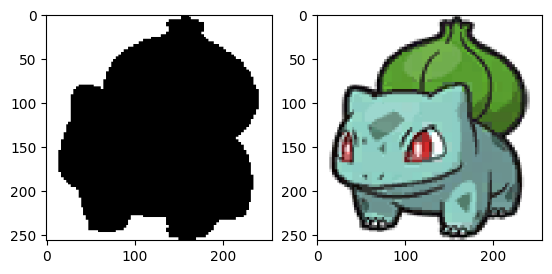

In [6]:
inp = load(str(f'{PATH_INPUT}/gen9/bulbasaur.png'))
re = load(str(f'{PATH_REAL}/gen9/bulbasaur.png'))
# Casting to int for matplotlib to display the images
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(inp / 255.0, cmap='gray')
axarr[1].imshow(re / 255.0)

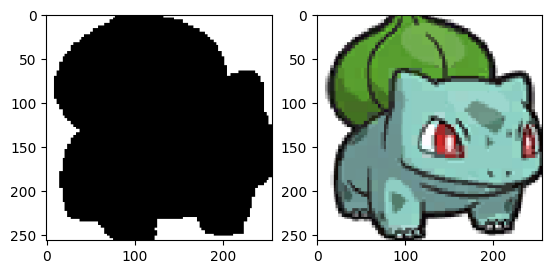

In [7]:
seed = gen_seed_pair()
rj_inp = random_jitter(inp, seed)
rj_re = random_jitter(re, seed)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(rj_inp / 255.0, cmap='gray')
axarr[1].imshow(rj_re / 255.0)

### Constroi pipeline

In [8]:
input_dataset = tf.data.Dataset.list_files(str(f'{PATH_INPUT}/*/*.png'), shuffle=False)
real_dataset = tf.data.Dataset.list_files(str(f'{PATH_REAL}/*/*.png'), shuffle=False)

# Zipa os DataSets:
all_dataset = tf.data.Dataset.zip(input_dataset, real_dataset)

# Mapeia:
all_dataset = all_dataset.map(load_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
all_dataset = all_dataset.batch(BATCH_SIZE)
all_dataset = all_dataset.shuffle(BUFFER_SIZE)

# Split
test_dataset = all_dataset.take(1000) 
train_dataset = all_dataset.skip(1000)

### Treinamento

#### Teste

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


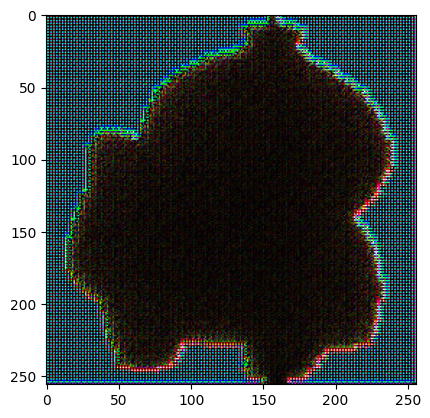

In [9]:
generator = Generator()
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [10]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  return total_gen_loss, gan_loss, l1_loss

#### Discriminador

In [11]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

(1, 30, 30, 1)


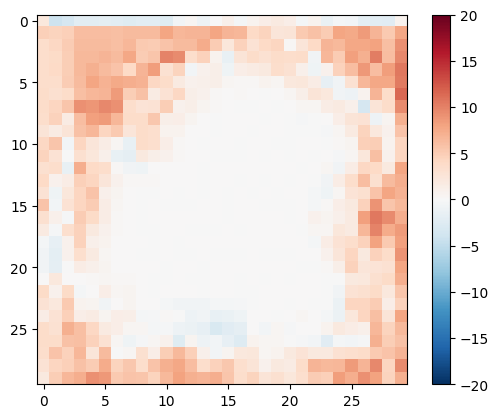

In [12]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
print(disc_out.shape)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Discriminador

In [13]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Define otimizador ADAM e checkpoint

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [15]:
checkpoint_dir = f'./{PATH_INPUT}_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

In [16]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
  plt.show()

In [ ]:
for example_input, example_target in all_dataset.take(1):
  generate_images(generator, example_input, example_target)

### Treinamento

In [1]:
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

NameError: name 'tf' is not defined

In [30]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [31]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
            start = time.time()
            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")
        train_step(input_image, target, step)
        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)
        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 1613.53 sec



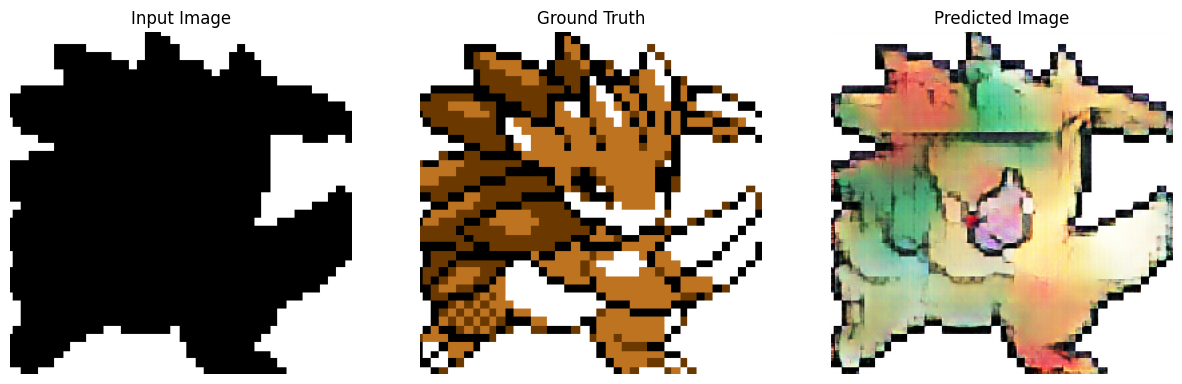

Step: 39k
....................................................................................................

In [32]:
fit(train_dataset, test_dataset, steps=40000)

In [4]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

NameError: name 'checkpoint' is not defined

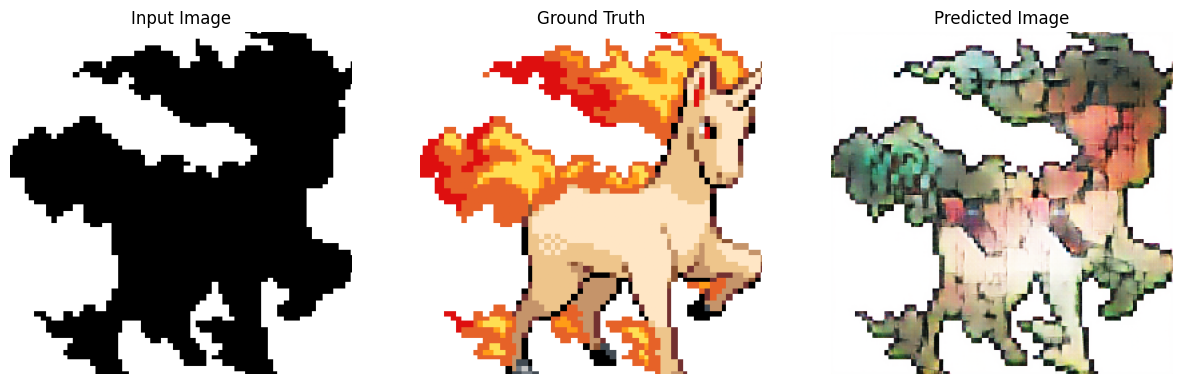

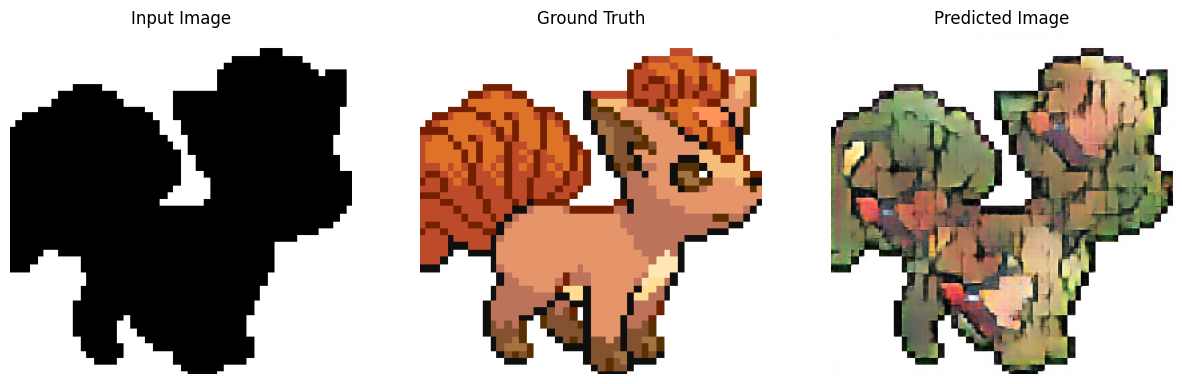

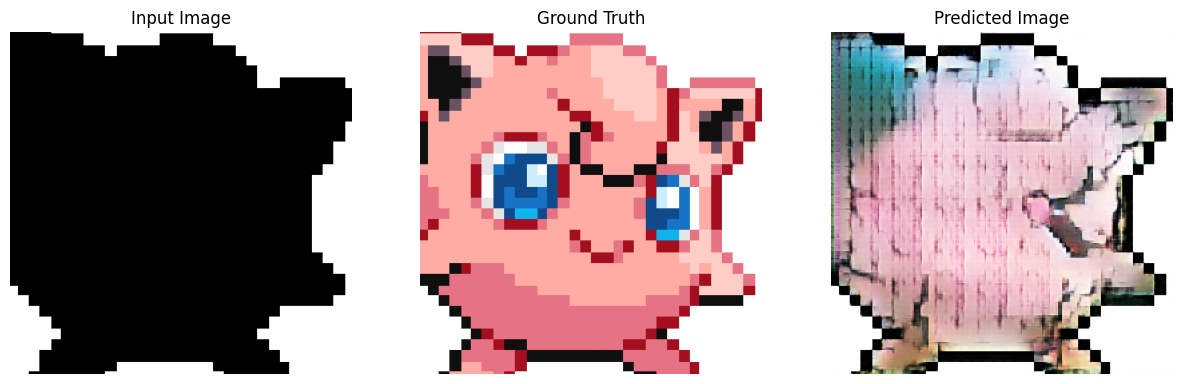

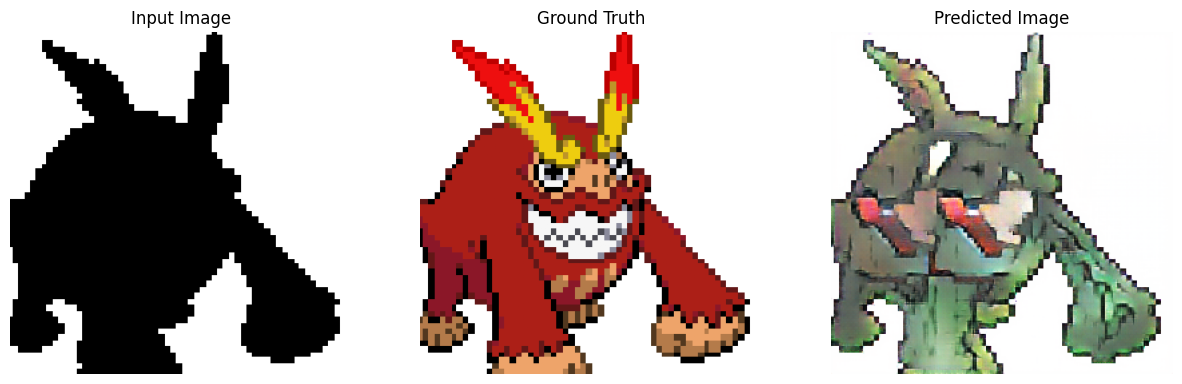

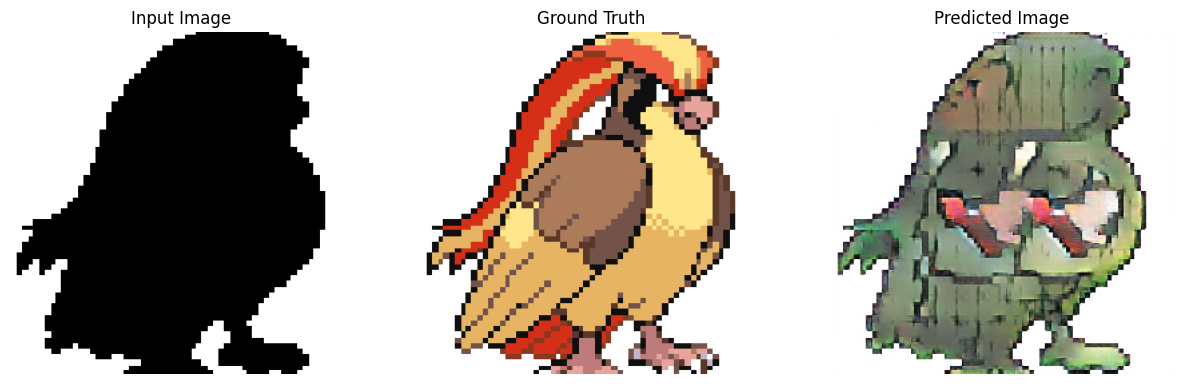

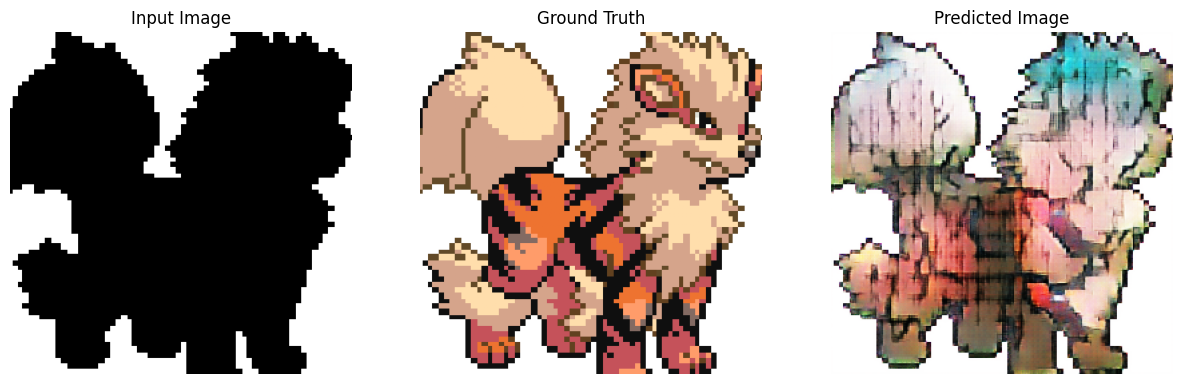

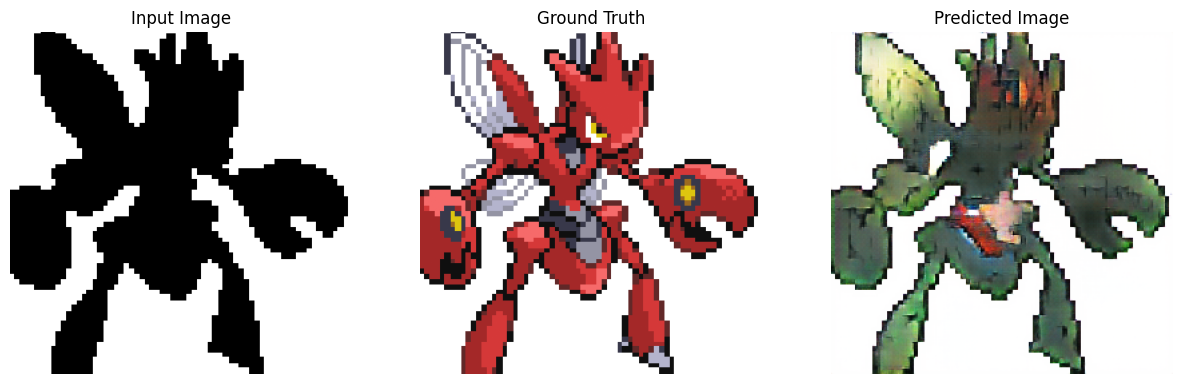

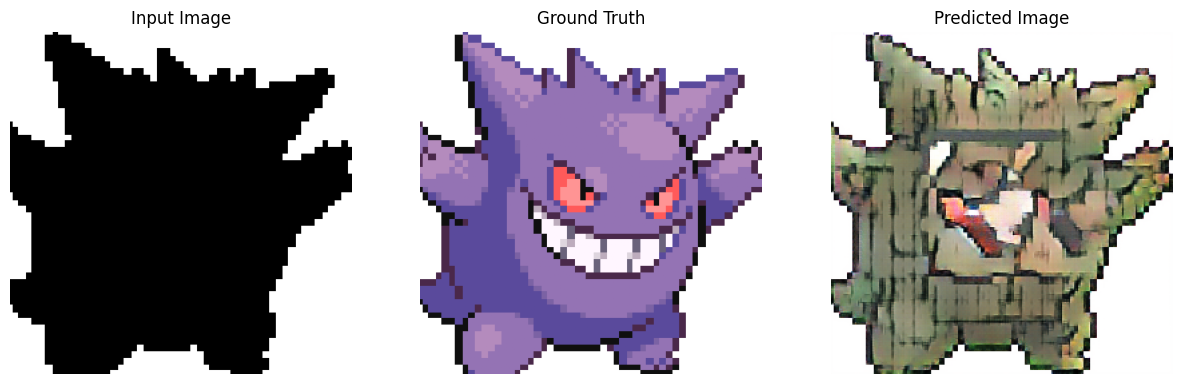

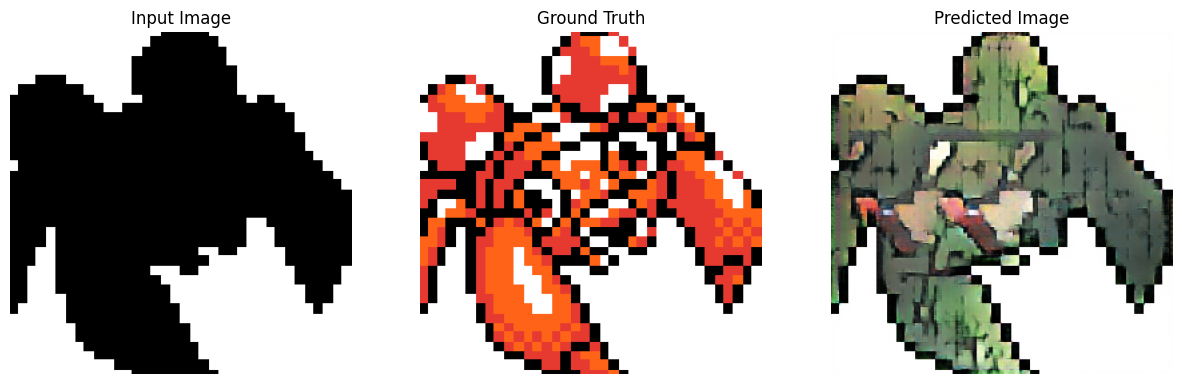

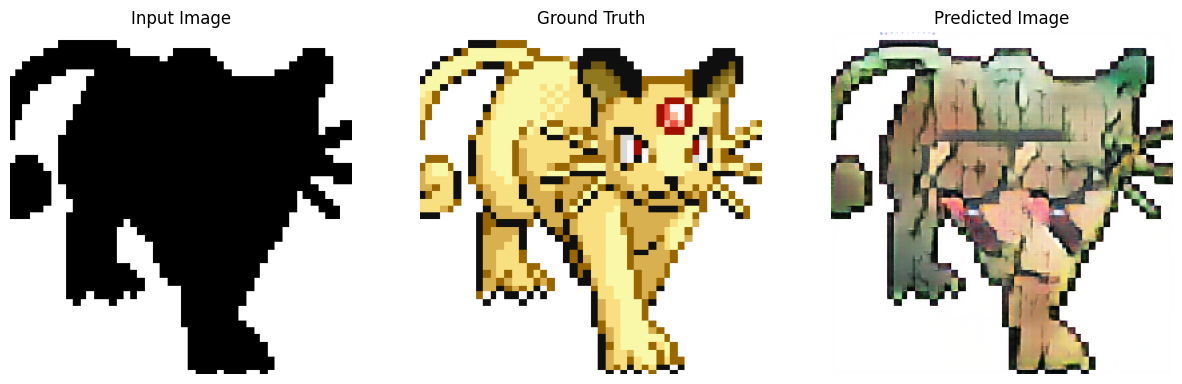

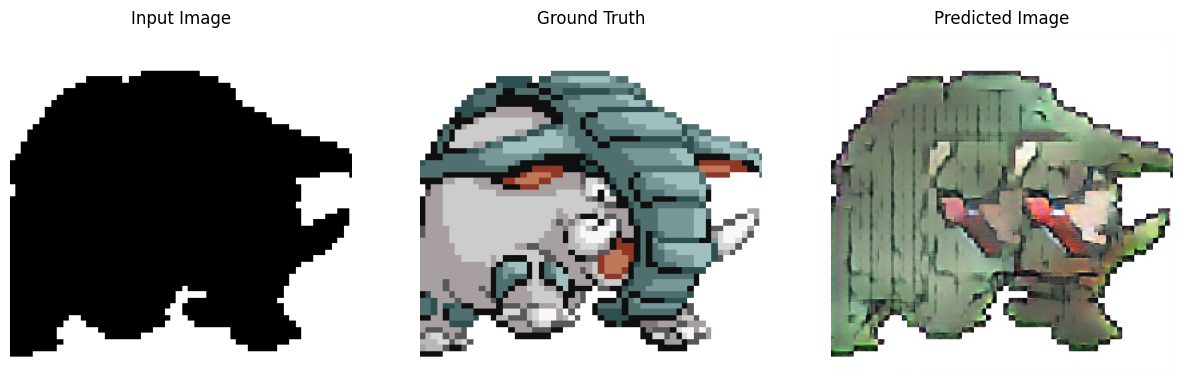

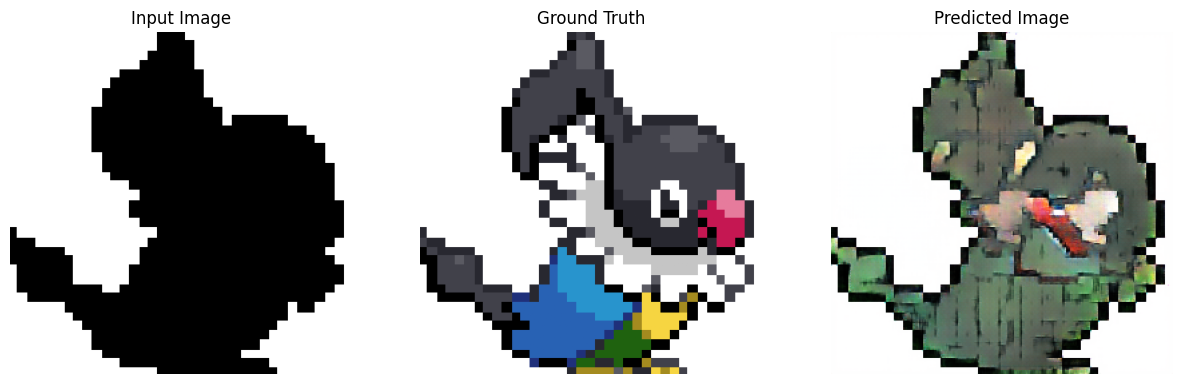

In [35]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(12):
    generate_images(generator, inp, tar)